# Regression Modeling in Practice
# Assignment: Test a Logistic Regression Model

Following is the Python program I wrote to fulfill the fourth assignment of the [Regression Modeling in Practice online course](https://www.coursera.org/learn/regression-modeling-practice/home/welcome).

I decided to use [Jupyter Notebook](http://nbviewer.jupyter.org/github/ipython/ipython/blob/3.x/examples/Notebook/Index.ipynb) as it is a pretty way to write code and present results.

## Research question for this assignment

For this assignment, I decided to use the NESARC database with the following question : *Are people from white ethnicity more likely to have ever used cannabis?*

The potential other explanatory variables will be:

- Age
- Sex
- Family income

## Data management

The data will be managed to get cannabis usage recoded from 0 (never used cannabis) and 1 (used cannabis). The non-answering recordings (reported as 9) will be discarded.

The response variable having 2 categories, categories grouping is not needed.

The other categorical variable (sex) will be recoded such that 0 means female and 1 equals male. And the two quantitative explanatory variables (age and family income) will be centered.


In [1]:
# Magic command to insert the graph directly in the notebook
%matplotlib inline
# Load a useful Python libraries for handling data
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Markdown, display

In [2]:
nesarc = pd.read_csv('nesarc_pds.csv')

C:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2723: DtypeWarning: Columns (76) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
canabis_usage = {1 : 1, 2 : 0, 9 : 9}
sex_shift = {1 : 1, 2 : 0}
white_race = {1 : 1, 2 : 0}

subnesarc = (nesarc[['AGE', 'SEX', 'S1Q1D5', 'S1Q7D', 'S3BQ1A5', 'S1Q11A']]
             .assign(sex=lambda x: pd.to_numeric(x['SEX'].map(sex_shift)),
                     white_ethnicity=lambda x: pd.to_numeric(x['S1Q1D5'].map(white_race)),
                     used_canabis=lambda x: (pd.to_numeric(x['S3BQ1A5'], errors='coerce')
                                                .map(canabis_usage)
                                                .replace(9, np.nan)),
                     family_income=lambda x: (pd.to_numeric(x['S1Q11A'], errors='coerce')))
             .dropna())

centered_nesarc = subnesarc.assign(age_c=subnesarc['AGE']-subnesarc['AGE'].mean(),
                                   family_income_c=subnesarc['family_income']-subnesarc['family_income'].mean())

In [4]:
display(Markdown("Mean age : {:.0f}".format(centered_nesarc['AGE'].mean())))
display(Markdown("Mean family income last year: {:.0f}$".format(centered_nesarc['family_income'].mean())))

Mean age : 46

Mean family income last year: 45631$

Let's check that the quantitative variable are effectively centered.

In [5]:
print("Centered age")
print(centered_nesarc['age_c'].describe())
print("\nCentered family income")
print(centered_nesarc['family_income_c'].describe())

Centered age
count    4.272500e+04
mean    -2.667486e-13
std      1.819181e+01
min     -2.841439e+01
25%     -1.441439e+01
50%     -2.414394e+00
75%      1.258561e+01
max      5.158561e+01
Name: age_c, dtype: float64

Centered family income
count    4.272500e+04
mean    -5.710829e-10
std      5.777221e+04
min     -4.560694e+04
25%     -2.863094e+04
50%     -1.263094e+04
75%      1.436906e+04
max      2.954369e+06
Name: family_income_c, dtype: float64


The means are both very close to 0; confirming the centering.

## Distributions visualization

The following plots shows the distribution of all 3 explanatory variables with the response variable.

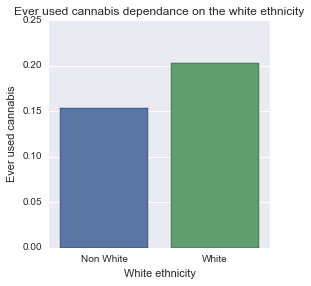

In [6]:
g = sns.factorplot(x='white_ethnicity', y='used_canabis', data=centered_nesarc, 
                   kind="bar", ci=None)
g.set_xticklabels(['Non White', 'White'])
plt.xlabel('White ethnicity')
plt.ylabel('Ever used cannabis')
plt.title('Ever used cannabis dependance on the white ethnicity');

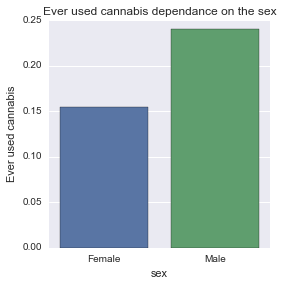

In [7]:
g = sns.factorplot(x='sex', y='used_canabis', data=centered_nesarc, 
                   kind="bar", ci=None)
g.set_xticklabels(['Female', 'Male'])
plt.ylabel('Ever used cannabis')
plt.title('Ever used cannabis dependance on the sex');

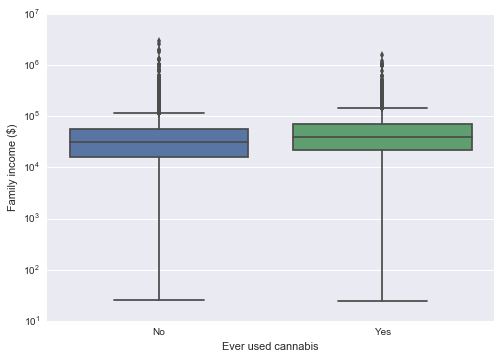

In [8]:
g = sns.boxplot(x='used_canabis', y='family_income', data=centered_nesarc)
g.set_yscale('log')
g.set_xticklabels(('No', 'Yes'))
plt.xlabel('Ever used cannabis')
plt.ylabel('Family income ($)');

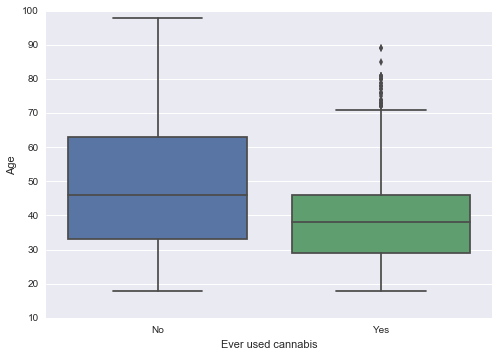

In [9]:
g = sns.boxplot(x='used_canabis', y='AGE', data=centered_nesarc)
g.set_xticklabels(('No', 'Yes'))
plt.xlabel('Ever used cannabis')
plt.ylabel('Age');

The four plots above show the following trends:
- More white people tries cannabis more than non-white
- Male people tries cannabis more than female
- Younger people tries cannabis more than older ones
- Man from richer families tries cannabis more than those from poorer families

## Logistic regression model

The plots showed the direction of a potential relationship. But a rigorous statistical test has to be carried out to confirm the four previous hypothesis.

The following code will test a logistic regression model on our hypothesis.

In [10]:
model = smf.logit(formula='used_canabis ~ family_income_c + age_c + sex + white_ethnicity', data=centered_nesarc).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.451313
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           used_canabis   No. Observations:                42725
Model:                          Logit   Df Residuals:                    42720
Method:                           MLE   Df Model:                            4
Date:                Sun, 24 Jul 2016   Pseudo R-squ.:                 0.07529
Time:                        16:15:55   Log-Likelihood:                -19282.
converged:                       True   LL-Null:                       -20852.
                                        LLR p-value:                     0.000
===================================================================================
                      coef    std err          z      P>|z|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept          -2.1043      0.032    -66.764      0.000        -2.166    -2.043
family_income_c  2.353e-06   2.16e-07     10.880      0.000      1.93e-06  2.78e-06
age_c              -0.0378      0.001    -45.288      0.000        -0.039    -0.036
sex                 0.5060      0.026     19.766      0.000         0.456     0.556
white_ethnicity     0.3583      0.032     11.268      0.000         0.296     0.421
===================================================================================
"""

In [11]:
params = model.params
conf = model.conf_int()
conf['Odds Ratios'] = params
conf.columns = ['Lower Conf. Int.', 'Upper Conf. Int.', 'Odds Ratios']
np.exp(conf)

,Lower Conf. Int.,Upper Conf. Int.,Odds Ratios
Intercept,0.114625,0.129699,0.121930
family_income_c,1.000002,1.000003,1.000002
age_c,0.961303,0.964455,0.962878
sex,1.577421,1.743910,1.658578
white_ethnicity,1.344412,1.522873,1.430863


## Confounders analysis

As all four variables coefficient have significant p-value (<< 0.05), no confounders are present in this model.

But as the pseudo R-Square has a really low value, the model does not really explain well the response variable. And so there is maybe a confounder variable that I have not test for.

## Summary

From the oods ratios results, we can conclude that:
- People with white ethnicity are more likely to have ever used cannabis (OR=1.43, 95% confidence int. [1.34, 1.52], p<.0005)

So the results support the hypothesis between our primary explanatory variable (white ethnicity) and the reponse variable (ever used cannabis)

- Male are more likely to have ever used cannabis than female (OR=1.66, 95% CI=[1.58, 1.74], p<.0005)
- People aged of less than 46 are more likely to have ever used cannabis (OR=0.963, 95% CI=[0.961, 0.964], p<.0005)


Regarding the last explanatory variable (family income), I don't if I can really conclude. Indeed from the strict resuts, people coming from richer family are more likely to have ever used cannabis (OR=1.000002, 95% CI=[1.000002, 1.000003], p<.0005). But the odds ratio is so close to 1.0 than I don't know if the difference is significant.